<a href="https://colab.research.google.com/github/iremond/Progetto_HLT/blob/main/BERT_multilingual_multiclass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys

!{sys.executable} -m pip install transformers[torch] datasets evaluate torch

zsh:1: no matches found: transformers[torch]


In [2]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [ ]:
%cd /content/drive/MyDrive/HLT

/content/drive/MyDrive/HLT


In [3]:
from datasets import load_dataset, Features, Value, ClassLabel
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, BertConfig, AutoConfig
import numpy as np
import evaluate
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Data loading

In [4]:
df_dev = load_dataset("csv", data_files="dataset/subtaskB_clean_dev_cased.csv")#, column_names=['text', 'label'])#, features=features)
df_test = load_dataset("csv", data_files="dataset/subtaskB_clean_test_cased.csv")#, column_names=['text', 'label'])#, features=features)

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /Users/elenascaglione/.cache/huggingface/datasets/csv/default-68f5b82fc8f19909/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /Users/elenascaglione/.cache/huggingface/datasets/csv/default-59f06b23b5ee1d21/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
df_dev = df_dev.rename_column("comment_text", "text")
df_dev = df_dev.rename_column("topic", "label")
df_test = df_test.rename_column("comment_text", "text")

In [6]:
class_names = ['Covid', 'Qanon', 'Russia', 'Terra Piatta']

In [7]:
label = ClassLabel(num_classes=4, names=class_names)
#features = Features({'text': Value('string'), 'label': ClassLabel(num_classes=4, names=class_names)})

In [8]:
df_dev = df_dev.cast_column("label", label)

Casting the dataset:   0%|          | 0/810 [00:00<?, ? examples/s]

In [9]:
df_dev

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 810
    })
})

In [10]:
np.unique(df_dev['train']['label'], return_counts=True)

(array([0, 1, 2, 3]), array([435, 242,  57,  76]))

# Data partioning

In [11]:
train_val = df_dev['train'].train_test_split(test_size=0.3, seed=42, stratify_by_column='label')
train_val

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 567
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 243
    })
})

In [12]:
df_train = train_val["train"]
df_val = train_val["test"]

In [13]:
df_val

Dataset({
    features: ['text', 'label'],
    num_rows: 243
})

In [14]:
np.unique(df_val['label'], return_counts=True)

(array([0, 1, 2, 3]), array([130,  73,  17,  23]))

# Model loading

In [15]:
nome = 'bert_base'
model_name = 'bert-base-multilingual-cased'

In [16]:
# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Data preprocessing

In [17]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

In [18]:
tokenized_train = df_train.map(tokenize_function, batched=True)
tokenized_val = df_val.map(tokenize_function, batched=True)
tokenized_test = df_test.map(tokenize_function, batched=True)

Map:   0%|          | 0/567 [00:00<?, ? examples/s]

Map:   0%|          | 0/243 [00:00<?, ? examples/s]

Map:   0%|          | 0/300 [00:00<?, ? examples/s]

In [19]:
tokenized_train

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 567
})

In [20]:
# small_train_dataset = tokenized_train.shuffle(seed=42).select(range(6))
# small_eval_dataset = tokenized_val.shuffle(seed=42).select(range(3))

# Training

In [21]:
label2id = {
    "Covid": 0,
    "QAnon": 1,
    "Russia": 2,
    "Terra Piatta": 3
}

In [22]:
id2label = {
    "0": 'Covid',
    "1": 'QAnon',
    "2": 'Russia',
    "3": 'Terra Piatta'
}

In [23]:
training_args = TrainingArguments(
    output_dir=f"{nome}-finetuned",
    evaluation_strategy = "epoch", # monitor the evaluation metrics during fine-tuning at the end of each epoch
    save_strategy = "epoch",
    logging_strategy="epoch",
    num_train_epochs=15,
    load_best_model_at_end=True, # the best model might not be the one at the end of training => we load the best saved model
    metric_for_best_model='eval_f1',
    seed=42
    #per_device_train_batch_size # default 8
    #per_device_eval_batch_size # default 8
    #learning_rate=0.0005, # default 0.00005
    #weight_decay=0.0001 # default 0 # disastro
    )

In [24]:
config = AutoConfig.from_pretrained(model_name, num_labels=len(label2id))
config.id2label = id2label
config.label2id = label2id


In [25]:
model = AutoModelForSequenceClassification.from_pretrained(model_name, config=config)#, num_labels=4)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual

Provare:

Optimizer: SGD, Adagrad,

Learning rate: 0.00005, ...

Dropout: 0.1, ...

In [26]:
model

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

In [27]:
model.config

BertConfig {
  "_name_or_path": "bert-base-multilingual-cased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "directionality": "bidi",
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "Covid",
    "1": "QAnon",
    "2": "Russia",
    "3": "Terra Piatta"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "Covid": 0,
    "QAnon": 1,
    "Russia": 2,
    "Terra Piatta": 3
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4.24.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 11

In [29]:
def compute_metrics(eval_pred):
  # takes as input model predictions, applies argmax to them and comput F-Score between predictions and true labels
  f1_metric = evaluate.load("f1")
  predictions, labels = eval_pred
  predictions = np.argmax(predictions, axis=1)
  return f1_metric.compute(predictions=predictions, references=labels, average="macro")

In [30]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_val,
    compute_metrics=compute_metrics
)

In [31]:
%%time
trainer.train()

The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/opt/anaconda3/lib/python3.9/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 567
  Num Epochs = 15
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1065
  Number of trainable parameters = 177856516


  0%|          | 0/1065 [00:00<?, ?it/s]

╭──────────────────────────── Traceback (most recent call last) ────────────────────────────╮
│                                                                                           │
│ /opt/anaconda3/lib/python3.9/site-packages/IPython/core/magics/execution.py:1327 in time  │
│                                                                                           │
│   1324 │   │   if mode=='eval':                                                           │
│   1325 │   │   │   st = clock2()                                                          │
│   1326 │   │   │   try:                                                                   │
│ ❱ 1327 │   │   │   │   out = eval(code, glob, local_ns)                                   │
│   1328 │   │   │   except:                                                                │
│   1329 │   │   │   │   self.shell.showtraceback()                                         │
│   1330 │   │   │   │   return                                                             │
│ <timed eval>:1 in <module>                                                                │
│                                                                                           │
│ /opt/anaconda3/lib/python3.9/site-packages/transformers/trainer.py:1501 in train          │
│                                                                                           │
│   1498 │   │   inner_training_loop = find_executable_batch_size(                          │
│   1499 │   │   │   self._inner_training_loop, self._train_batch_size, args.auto_find_batc │
│   1500 │   │   )                                                                          │
│ ❱ 1501 │   │   return inner_training_loop(                                                │
│   1502 │   │   │   args=args,                                                             │
│   1503 │   │   │   resume_from_checkpoint=resume_from_checkpoint,                         │
│   1504 │   │   │   trial=trial,                                                           │
│                                                                                           │
│ /opt/anaconda3/lib/python3.9/site-packages/transformers/trainer.py:1749 in                │
│ _inner_training_loop                                                                      │
│                                                                                           │
│   1746 │   │   │   │   │   with model.no_sync():                                          │
│   1747 │   │   │   │   │   │   tr_loss_step = self.training_step(model, inputs)           │
│   1748 │   │   │   │   else:                                                              │
│ ❱ 1749 │   │   │   │   │   tr_loss_step = self.training_step(model, inputs)               │
│   1750 │   │   │   │                                                                      │
│   1751 │   │   │   │   if (                                                               │
│   1752 │   │   │   │   │   args.logging_nan_inf_filter                                    │
│                                                                                           │
│ /opt/anaconda3/lib/python3.9/site-packages/transformers/trainer.py:2508 in training_step  │
│                                                                                           │
│   2505 │   │   │   return loss_mb.reduce_mean().detach().to(self.args.device)             │
│   2506 │   │                                                                              │
│   2507 │   │   with self.compute_loss_context_manager():                                  │
│ ❱ 2508 │   │   │   loss = self.compute_loss(model, inputs)                                │
│   2509 │   │                                                                              │
│   2510 │   │   if self.args.n_gpu > 1:                                                    │
│   2511 │   │   │   loss = loss.mean()  # mean() to

# Evaluation

In [ ]:
log_history = trainer.state.log_history

In [ ]:
df = pd.DataFrame(columns=["Epoch", "Loss", "Dataset"])

for log_data in log_history:
  epoch = int(log_data["epoch"])
  if "loss" in log_data.keys():
    loss = log_data["loss"]
    df = df.append({"Epoch": epoch, "Loss": loss, "Dataset": "Training"}, ignore_index=True)
  if "eval_loss" in log_data.keys():
    loss = log_data["eval_loss"]
    df = df.append({"Epoch": epoch, "Loss": loss, "Dataset": "Validation"}, ignore_index=True)
df

<ipython-input-45-ea7900ceb47e>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Epoch": epoch, "Loss": loss, "Dataset": "Training"}, ignore_index=True)
<ipython-input-45-ea7900ceb47e>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Epoch": epoch, "Loss": loss, "Dataset": "Validation"}, ignore_index=True)
<ipython-input-45-ea7900ceb47e>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Epoch": epoch, "Loss": loss, "Dataset": "Training"}, ignore_index=True)
<ipython-input-45-ea7900ceb47e>:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append({"Epoch": epoch, "Loss": loss, "Da

,Epoch,Loss,Dataset
0,1,0.792400,Training
1,1,0.618374,Validation
2,2,0.606300,Training
3,2,0.827486,Validation
4,3,0.386700,Training
5,3,0.836602,Validation
6,4,0.353900,Training
7,4,0.853507,Validation
8,5,0.211200,Training
9,5,0.679335,Validation


In [ ]:
from IPython.display import HTML

df.to_html(f'subtaskB/loss_{nome}.html')

display(HTML(f'subtaskB/loss_{nome}.html'))

,Epoch,Loss,Dataset
0,1,0.792400,Training
1,1,0.618374,Validation
2,2,0.606300,Training
3,2,0.827486,Validation
4,3,0.386700,Training
5,3,0.836602,Validation
6,4,0.353900,Training
7,4,0.853507,Validation
8,5,0.211200,Training
9,5,0.679335,Validation


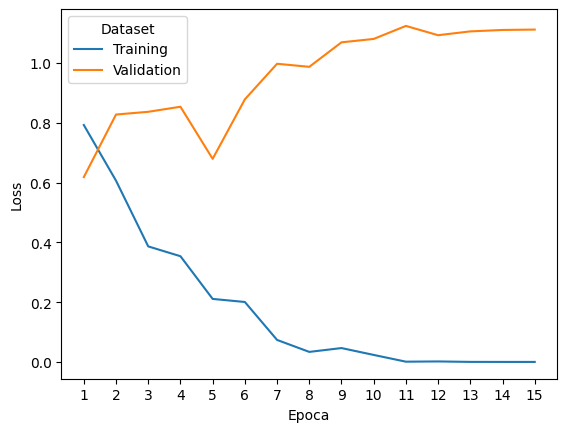

In [ ]:
# loss lineplot
sns.lineplot(data=df, x="Epoch", y="Loss", hue="Dataset")
plt.xticks(range(1, 16))
plt.xlabel('Epoca')
plt.savefig(f'subtaskB/loss_curves_{nome}.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
output_predictions = trainer.predict(tokenized_val)

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
y_val = tokenized_val["label"]
y_val_pred = np.argmax(output_predictions.predictions, axis=1)

report = classification_report(y_val, y_val_pred)
print(report)

              precision    recall  f1-score   support

           0       0.87      0.91      0.89       130
           1       0.78      0.74      0.76        73
           2       0.86      0.71      0.77        17
           3       0.88      0.91      0.89        23

    accuracy                           0.84       243
   macro avg       0.85      0.82      0.83       243
weighted avg       0.84      0.84      0.84       243



In [ ]:
with open(f"subtaskB/class_report_{nome}.html", "w") as file:
    file.write(report)

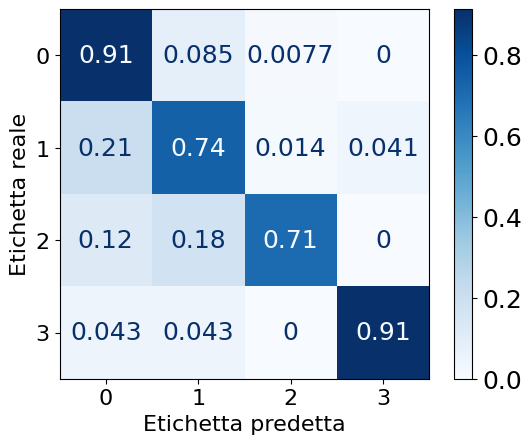

In [ ]:
plt.rcParams.update({'font.size': 18})
ConfusionMatrixDisplay.from_predictions(y_val, y_val_pred, cmap='Blues', normalize='true')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Etichetta predetta', fontsize=16)
plt.ylabel('Etichetta reale', fontsize=16)
plt.savefig(f'subtaskB/conf_matrix_{nome}.pdf', dpi=300, bbox_inches='tight')
plt.show()